###  THE TITANIC AND MOVIE DATASETS

In [157]:
from itertools import product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from patsy import dmatrices
from sklearn import linear_model as lm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import naive_bayes
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings("ignore")

In [116]:
df = pd.read_csv('data/titanic.csv')


### Titanic

1.Read in the titanic data set. Use a for loop to find the best nearest neighbor parameter. 

In [117]:
# insert
df = pd.read_csv('data/titanic.csv')
sex = pd.get_dummies(df['Sex'])
df = df.join(sex)
# df = df.drop(columns=['Sex'])
X = df.drop(columns = ['Survived','Name','Sex'])
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=0)
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
k_scores = []

for k in range(1, 20):

    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=3, scoring='accuracy')
    
    k_scores.append((k, scores.mean()))
    
k_scores = pd.DataFrame(k_scores, columns=['k', 'accuracy']).set_index('k')
k_max = k_scores[k_scores.accuracy==max(k_scores.accuracy)]
k_max

,accuracy
k,
16,0.822544


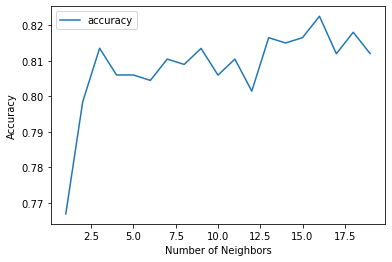

In [118]:
ax = k_scores.plot()
ax.set(xlabel='Number of Neighbors', ylabel='Accuracy');

2.Now use GridSearchCV to find the optimal parameter.

In [119]:
# insert 2
from sklearn.model_selection import GridSearchCV

# create a parameter grid: map the parameter names to the values that should be searched
# Grid search uses all the parameters

param_grid = {'n_neighbors': range(1, 20)}

model = GridSearchCV(KNeighborsClassifier(), 
                    param_grid, 
                    cv=3, 
                    scoring='accuracy')

model = model.fit(X_train, y_train)
print(model.best_params_, model.best_estimator_)

{'n_neighbors': 16} KNeighborsClassifier(n_neighbors=16)


3.Print a classification report. Describe in words what the recall and precision represent.

In [120]:
# insert 3
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       142
           1       0.74      0.69      0.71        80

    accuracy                           0.80       222
   macro avg       0.79      0.78      0.78       222
weighted avg       0.80      0.80      0.80       222



### Interpretations
- With a precision score of 83%, out of all cases predicted as not survived, we were correct 83% of the time. With a recall score of 87%, out of all not survived passengers, we found 87% of them.
- With a precision score of 74%, out of all cases predicted as survived, we were correct 74% of the time. With a recall score of 69%, out of all survived passengers, we found 69% of them.

4.Print a confusion matrix. How many people got classified incorrectly? Make sure you understand which category is which.

In [127]:
# insert 4
y_test = np.array(y_test).reshape(-1,1)
confusion_matrix(y_test, model.predict(X_test))

array([[123,  19],
       [ 25,  55]])

### Confusion Matrix
    There is 19 + 25 = 44 people got classified incorrectly. 19 is predicted to be survived but actually dead, and 25 predicted to be dead actually survived.

5.Print the accuracy and ROC-AUC for each of the 4 models: Naive Bayes, Logistic Regresion, Gradient Boosting, and K Nearest Neighbors.

In [136]:
# insert 5
model0 = LogisticRegression(multi_class = "auto", solver = 'lbfgs', max_iter=10000)
model0.fit(X_train, y_train)

# accuracy for test & train:    
y_proba_LR = model0.predict_proba(X_test)[:, 1]

# calculate AUC
print('Logistic Model accuracy:', model0.score(X_test,y_test))
print('ROC-AUC:', roc_auc_score(y_test, y_proba_LR))
print()

model1 = GradientBoostingClassifier()
model1.fit(X_train, y_train)

# accuracy for test & train:    
y_proba_GB = model1.predict_proba(X_test)[:, 1]

#calculate AUC
print('Gradient Boosting Model accuracy:', model1.score(X_test,y_test))
print('ROC-AUC:', roc_auc_score(y_test, y_proba_GB))
print()

model2 = naive_bayes.GaussianNB()
model2.fit(X_train, y_train)
   
y_proba_NB = model2.predict_proba(X_test)[:, 1]
#calculate AUC
print('NAVIE Bayes Model accuracy:', model2.score(X_test,y_test))
print('ROC-AUC:', roc_auc_score(y_test, y_proba_GB))
print()

model3 = GridSearchCV(KNeighborsClassifier(n_neighbors=16), 
                    param_grid, 
                    cv=3, 
                    scoring='accuracy')
model3.fit(X_train, y_train)
y_proba_KNN = model3.predict_proba(X_test)[:, 1]
print('KNN Model accuracy:', model3.score(X_test,y_test))
print('ROC-AUC:', roc_auc_score(y_test, y_proba_KNN))
print()

Logistic Model accuracy: 0.8018018018018018
ROC-AUC: 0.8485035211267606

Gradient Boosting Model accuracy: 0.8153153153153153
ROC-AUC: 0.8537411971830986

NAVIE Bayes Model accuracy: 0.7792792792792793
ROC-AUC: 0.8537411971830986

KNN Model accuracy: 0.8018018018018018
ROC-AUC: 0.8566461267605634



6.Plot ROC curves comparing the four methods.

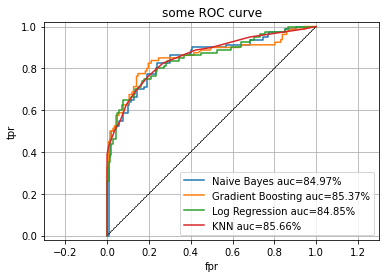

In [137]:
# insert 6
def plot_roc(ytrue, yproba, model, title='some ROC curve'):
    auc = roc_auc_score(ytrue, yproba)
    fpr, tpr, thr = roc_curve(ytrue, yproba)
    plt.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=.4)
    plt.plot(fpr, tpr, label='{} auc={:.2f}%'.format(model, auc*100))
    plt.axis('equal')
    plt.xlim([-.02, 1.02])
    plt.ylim([-.02, 1.02])
    plt.ylabel('tpr')
    plt.xlabel('fpr')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    
plot_roc(y_test, y_proba_NB, "Naive Bayes")
plot_roc(y_test, y_proba_GB, "Gradient Boosting")
plot_roc(y_test, y_proba_LR, "Log Regression")
plot_roc(y_test, y_proba_KNN, "KNN")

### MOVIE

7.Read in the "2013_movies.csv" movie dataset below. Drop the Title, Director, and ReleaseDate columns. Then use a logistic regression model to predic the rating for the movie. What is the test accuracy?

In [149]:
# insert 7
df = pd.read_csv(
    'data/2013_movies.csv'
)
# df = df.drop(columns=['Title', 'Director', 'ReleaseDate'])
X = df.drop(columns = ['Title', 'Director', 'ReleaseDate','Rating'])
y = df['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)

model = LogisticRegression(multi_class = "auto", solver = 'lbfgs', max_iter=10000)
model.fit(X_train, y_train)

# accuracy for test & train:    
y_proba_LR = model.predict_proba(X_test)[:, 1]

# calculate AUC
print('accuracy:', model.score(X_test,y_test))

accuracy: 0.4583333333333333


In [156]:
model.predict(X_test)

array(['G', 'PG-13', 'PG-13', 'R', 'PG-13', 'PG-13', 'PG-13', 'PG-13',
       'R', 'PG-13', 'PG-13', 'PG-13', 'PG-13', 'PG-13', 'PG-13', 'PG-13',
       'PG-13', 'PG-13', 'PG-13', 'PG-13', 'PG-13', 'PG-13', 'PG-13',
       'PG-13'], dtype=object)

8.Print the classes and the confusion matrix for the classes. What were most movies predicted to be?

In [159]:
# insert 8
print(classification_report(y_test, model.predict(X_test)))
confusion_matrix(y_test, model.predict(X_test))

              precision    recall  f1-score   support

           G       0.00      0.00      0.00         0
          PG       0.00      0.00      0.00         4
       PG-13       0.48      0.83      0.61        12
           R       0.50      0.12      0.20         8

    accuracy                           0.46        24
   macro avg       0.24      0.24      0.20        24
weighted avg       0.40      0.46      0.37        24



array([[ 0,  0,  0,  0],
       [ 0,  0,  4,  0],
       [ 1,  0, 10,  1],
       [ 0,  0,  7,  1]])

### MOST predicted movie: PG-13

9.Print the classification report. Any interesting findings?

In [160]:
# insert 9
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           G       0.00      0.00      0.00         0
          PG       0.00      0.00      0.00         4
       PG-13       0.48      0.83      0.61        12
           R       0.50      0.12      0.20         8

    accuracy                           0.46        24
   macro avg       0.24      0.24      0.20        24
weighted avg       0.40      0.46      0.37        24



### Findings
    The recall(True Postiive Rate) of PG-13 is very high.